# Naive Bayes for text categorization


In [1]:
import re
import math
import random
import numpy as np
import matplotlib.pyplot as plt

### Reading data file

In [2]:
data_set = []
labels = []
data_path1 = 'amazon_cells_labelled.txt'
data_path2 = 'imdb_labelled.txt'
data_path3 = 'yelp_labelled.txt'
with open(data_path1) as dp:
    line = dp.readline()
    while line:
        data_set.append(line.strip())
        line = dp.readline()

### Organizing data

In [3]:
def createData(dataset):
    d = [i[:-3] for i in dataset]
    d = [item.lower() for item in d]
    for i in range(len(d)):
        d[i] = re.sub('[^A-Za-z0-9-\s]+', '', d[i])
    l = [i[-1:] for i in dataset]
    for i in range(0, len(l)): 
        l[i] = int(l[i])
    dataset = list(zip(d , l))
    
    return dataset

In [4]:
dataset = createData(data_set)

### Class distribution


In [5]:
def classDistribution(dataset):
    
    dataset_class_1 = []
    dataset_class_0 = []
    
    for i in range(len(dataset)):
        if dataset[i][1] == 1:
            dataset_class_1.append(dataset[i])
        else:
            dataset_class_0.append(dataset[i])
            
    dataset_class_1 = random.sample(dataset_class_1,len(dataset_class_1))
    
    dataset_class_0 = random.sample(dataset_class_0,len(dataset_class_0))
    
    return dataset_class_0, dataset_class_1

In [6]:
dataset_class_0, dataset_class_1 = classDistribution(dataset)

### Train and Test Split

In [7]:
def train_test_split(dataset, value):
    index = int(value*len(dataset))
    train = dataset[:index]
    test = dataset[index:]
    
    return train, test

In [8]:
train_1, test_1 = train_test_split(dataset_class_1,0.8)
train_0, test_0 = train_test_split(dataset_class_0,0.8)

### Token Calculation

In [9]:
def generate_token(data):
    c_words = {}               # Vocabulary of words in class 1
    total_words = 0            # Total words in class 1
    for i in range(len(data)):
        for word in data[i][0].split(" "):
            total_words += 1
            if(word in c_words):
                c_words[word] +=1
            else:
                c_words[word] = 1
    return c_words,total_words

In [10]:
c_words_1,total_words_1 = generate_token(train_1)
c_words_0,total_words_0 = generate_token(train_0)

### Creating training and testing dataset

In [11]:
train = train_1 + train_0

In [12]:
train_ran = random.sample(train,len(train))

In [13]:
test = test_1 + test_0

In [14]:
test_ran = random.sample(test,len(test))

In [15]:
train_data = []
train_label = []
for i in range(len(train_ran)):
    train_data.append(train_ran[i][0])
    train_label.append(train_ran[i][1])


In [16]:
test_data = []
test_label = []
for i in range(len(test_ran)):
    test_data.append(test_ran[i][0])
    test_label.append(test_ran[i][1])

### Creating Dictionary


In [17]:
def create_dict(data):
    
    vocab = {}
    total_words = 0
    
    for i in range(len(data)):
        for word in data[i][0].split(" "):
            total_words += 1
            if(word in vocab):
                vocab[word] +=1
            else:
                vocab[word] = 1
    return vocab,total_words

In [18]:
vocab,total_words = create_dict(train)

### Prior

In [19]:
def generate_prior(train_class,data):
    maxL = math.log(len(train_class)/(len(data)))
    
    return maxL

In [20]:
maxL_0 = generate_prior(train_0,train)
maxL_1 = generate_prior(train_1,train)

### Prediction Function

In [21]:
def prediction(maxL_0,maxL_1,tokens_0,tokens_1,test):
    
    y_prime = []
    accuracy = 0
    
    for i in range(len(test)):
        
        pred_0 = maxL_0
        pred_1 = maxL_1
        
        for word in test[i][0].split(" "):
            word = word.lower()
            if tokens_0.__contains__(word):
                pred_0 += tokens_0[word]
            if tokens_1.__contains__(word):    
                pred_1 += tokens_1[word]
    
        if pred_0 > pred_1:
            y_prime.append(0)
        else: 
            y_prime.append(1)
        
        if y_prime[i] == test[i][1]:
            accuracy += 1
    
    total_accuracy = accuracy/len(test)
    
    return total_accuracy

### Generalized function for MAP

In [22]:
def calculate_MAP(vocab_data,vocab_class,total_words_class,m):
    MAP_tokens = {}
    vocab_len = len(vocab_data)
    
    for word in vocab_data:
        if vocab_class.__contains__(word):
            MAP_tokens[word] = math.log((vocab_class[word] + m)/(total_words_class + (vocab_len*m)))
        else:
            if m != 0:
                MAP_tokens[word] = math.log((m)/(total_words_class + (vocab_len*m)))
    return MAP_tokens
    

In [23]:
maxL_tokens_0 = calculate_MAP(vocab,c_words_0,total_words_0,0)
maxL_tokens_1 = calculate_MAP(vocab,c_words_1,total_words_1,0)

In [24]:
MAP_tokens_0 = calculate_MAP(vocab,c_words_0,total_words_0,1)
MAP_tokens_1 = calculate_MAP(vocab,c_words_1,total_words_1,1)

### Function to find average

In [25]:
def avg(array): 
    return (sum(array)/len(array)) 

### k Fold Cross Validation

In [26]:
def kfold_cross_validation(train0,train1,k,m,q):
    
    train_0 = random.sample(train0,len(train0))
    train_1 = random.sample(train1,len(train1))
    
    fold_break = int(len(train_0)/k)
    
    MAP_curve_accuracy = np.zeros((10, 10))
    
    MAP_smooth_accuracy = []
    
    sd_maxL = []
    sd_MAP = []

    cv_test_0 = []
    cv_test_1 = []
    cv_train_0 = []
    cv_train_1 = []

    for i in range(k):
        if i == 0:
            cv_test_0 = train_0[(i*fold_break):((i+1)*fold_break)]
            cv_train_0 = train_0[(i+1)*fold_break:]

            cv_test_1 = train_1[i*fold_break:(i+1)*fold_break]
            cv_train_1 = train_1[(i+1)*fold_break:]
        if i == (k-1):
            cv_test_0 = train_0[i*fold_break:(i+1)*fold_break]
            cv_train_0 = train_0[:(i)*fold_break]

            cv_test_1 = train_1[i*fold_break:(i+1)*fold_break]
            cv_train_1 = train_1[:(i)*fold_break]
        else:
            cv_test_0 = train_0[i*fold_break:(i+1)*fold_break]
            cv_train_0 = train_0[:(i)*fold_break] + train_0[(i+1)*fold_break:]

            cv_test_1 = train_1[i*fold_break:(i+1)*fold_break]
            cv_train_1 = train_1[:(i)*fold_break] + train_1[(i+1)*fold_break:]
            
            
        # Now we have cv_test_0, cv_train_0, cv_test_1, cv_train_1
        if q == 1:
            for l in range(10):

                new_train_1 = cv_train_1[:int(((l+1)*len(cv_train_1)/10))]
                new_train_0 = cv_train_0[:int(((l+1)*len(cv_train_0)/10))]

                vocab,total_words = create_dict(new_train_1 + new_train_0)

                vocab_1,total_words_1 = create_dict(new_train_1)
                vocab_0,total_words_0 = create_dict(new_train_0)

                maxL_0 = generate_prior(new_train_0,new_train_1+new_train_0)
                maxL_1 = generate_prior(new_train_1,new_train_1+new_train_0)

                MAP_tokens_0 = calculate_MAP(vocab,vocab_0,total_words_0,m)
                MAP_tokens_1 = calculate_MAP(vocab,vocab_1,total_words_1,m)

                MAP_curve_accuracy[i][l] = prediction(maxL_0,maxL_1,MAP_tokens_0,MAP_tokens_1,cv_test_1+cv_test_0)
                
            
        if q == 2:
            new_train_1 = cv_train_1
            new_train_0 = cv_train_0

            vocab,total_words = create_dict(new_train_1 + new_train_0)

            vocab_1,total_words_1 = create_dict(new_train_1)
            vocab_0,total_words_0 = create_dict(new_train_0)

            maxL_0 = generate_prior(new_train_0,new_train_1+new_train_0)
            maxL_1 = generate_prior(new_train_1,new_train_1+new_train_0)

            MAP_tokens_0 = calculate_MAP(vocab,vocab_0,total_words_0,m)
            MAP_tokens_1 = calculate_MAP(vocab,vocab_1,total_words_1,m)

            MAP_smooth_accuracy.append(prediction(maxL_0,maxL_1,MAP_tokens_0,MAP_tokens_1,cv_test_1+cv_test_0))
    
    if q == 2:
        mean = np.mean(MAP_smooth_accuracy,axis=0)
        sd = np.std(MAP_smooth_accuracy,axis=0)
        return mean,sd
    
    if q ==1:
        mean = np.mean(MAP_curve_accuracy, axis=0)
        sd = np.std(MAP_curve_accuracy, axis=0)
        return mean,sd

In [27]:
mean_MAP,sd_MAP = kfold_cross_validation(dataset_class_0, dataset_class_1,10,1,1)

In [28]:
mean_MLE,sd_MLE = kfold_cross_validation(dataset_class_0, dataset_class_1,10,0,1)

### Bar Graph Plot

In [39]:
def plot_errorbar(mean_MAP,sd_MAP,mean_MLE,sd_MLE):
    
    index = np.arange(10)

    x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    
    y1 = mean_MAP
    yerr1 = sd_MAP
    y2 = mean_MLE
    yerr2 = sd_MLE
    
    plt.figure(200)
    plt.errorbar(x,y1,yerr1)
    plt.errorbar(x,y2,yerr2)
    plt.title("Relationship between accuracy and train-set size")
    plt.gca().legend(('MAP(m=1)','MLE(m=0)'))
    plt.xlabel('Function of train-set size')
    plt.ylabel('Averages of accuracy')
    plt.xticks(x)
    plt.tick_params(axis="x", labelsize=9)
    fig = plt.gcf()
    fig.set_size_inches(10,7)
    #plt.savefig('pp1_5.png')
    plt.show()

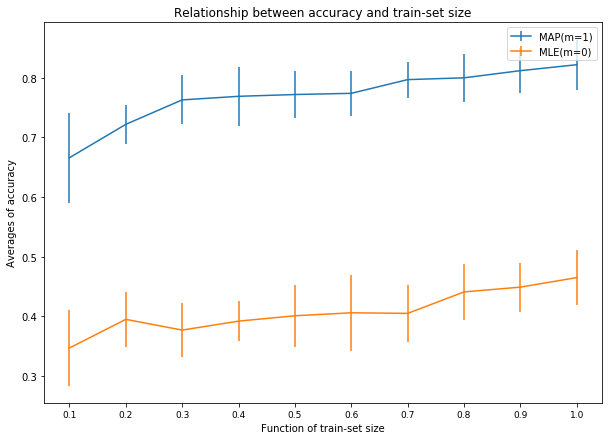

In [40]:
plot_errorbar(mean_MAP,sd_MAP,mean_MLE,sd_MLE)

### cross validation accuracy and SD as a function of the smoothing parameter

In [41]:
smooth_mean = []
smooth_sd = []
for i in range(10):
    s_mean,s_sd = kfold_cross_validation(dataset_class_0, dataset_class_1,10,(i/10),2)
    smooth_mean.append(s_mean)
    smooth_sd.append(s_sd)
for j in range(10):
    s_mean,s_sd = kfold_cross_validation(dataset_class_0, dataset_class_1,10,(j+1),2)
    smooth_mean.append(s_mean)
    smooth_sd.append(s_sd)

In [42]:
def single_error_plot(y,yerr):
    # example variable error bar values
    x = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]
    plt.figure(300)
    plt.errorbar(x,y,yerr)
    plt.title("Relationship between accuracy and smoothing parameter(m)")
    plt.legend(('m'))
    plt.xlabel('Function of m')
    plt.ylabel('Averages of accuracy')
    plt.xticks(x)
    plt.tick_params(axis="x", labelsize=9)
    fig = plt.gcf()
    fig.set_size_inches(14,11)
    plt.savefig('pp1_2.png')
    plt.show()

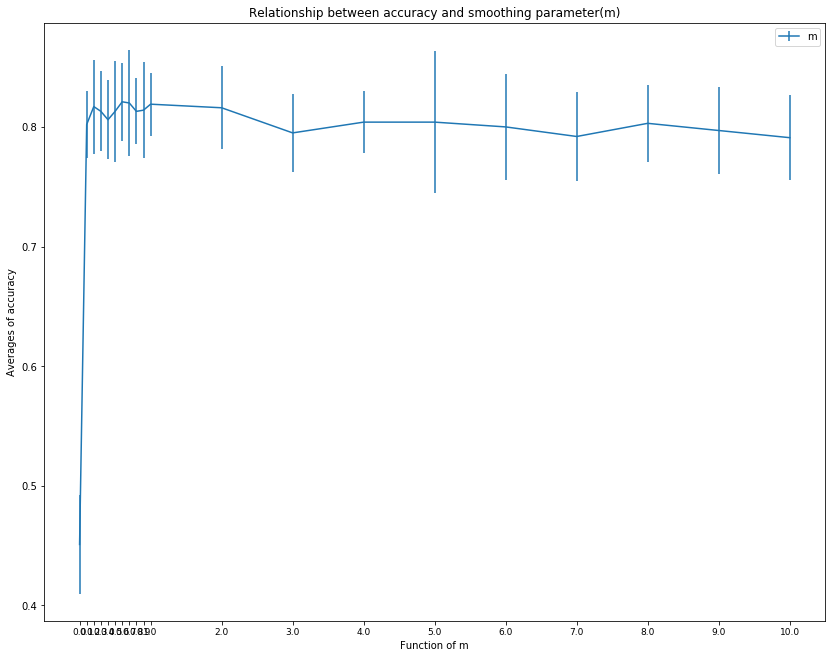

In [43]:
single_error_plot(smooth_mean,smooth_sd)